In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
df = pd.read_csv("Fact_sales.csv")
product_df = pd.read_csv("DIM_PRODUCT.csv", encoding='latin1')
customer_df = pd.read_csv("DIM_CUSTOMER.csv", encoding='latin1')
df = df.merge(product_df, on='Product ID', how="left")
df = df.merge(customer_df, on='Customer ID', how="left")

In [40]:
df["Profit"] = df["Profit"].astype(str).str.replace(",", "").astype(float)

In [41]:
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Month"] = df["Order Date"].dt.month
df["Day"] = df["Order Date"].dt.day

df["Sales*Quantity"] = df["Sales"] * df["Quantity"]

In [42]:
df = df.drop_duplicates(subset=['Order ID'])

In [43]:
df_new = df.copy()
categorical = ["Category","Segment"]
df_new = pd.get_dummies(df_new, columns=categorical, drop_first=True)

not_needed = ["Return_lable","Discount_Label","Order_to_Ship_Time","ORDERPRIORITY_ID",
              "MARKET_ID"]

features = ["Sales","Quantity","Discount","Month","Day","Sales*Quantity","MARKET_ID","ORDERPRIORITY_ID"] + [c for c in df_new.columns if "_" in c and c not in not_needed]

X = df_new[features]
y = df_new["Profit"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
def normalize_features(X):
   X = (X - X.mean()) / X.std()
   return X

In [46]:
X_train = normalize_features(X_train)
X_test = normalize_features(X_test)

In [47]:
model_rf = RandomForestRegressor(
    n_estimators = 400,
    max_depth = 20,
    min_samples_leaf = 2,
    n_jobs = -1,
    random_state = 42
)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest R2 Score:", round(r2_rf, 4))
print("Random Forest MSE:", round(mse_rf, 4))

Random Forest R2 Score: 0.6889
Random Forest MSE: 8684.8538


In [48]:
model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.05, min_child_weight=2, n_jobs=-1, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost R2 Score:", round(r2_xgb, 4))
print("XGBoost MSE:", round(mse_xgb, 4))

XGBoost R2 Score: 0.4988
XGBoost MSE: 13992.6471


In [49]:
importances = pd.DataFrame({"Feature": features, "Importance": model_rf.feature_importances_})
print(importances.sort_values("Importance", ascending=False))

                     Feature  Importance
0                      Sales    0.525347
2                   Discount    0.256847
5             Sales*Quantity    0.089388
9                LOCATION_ID    0.031790
4                        Day    0.025385
3                      Month    0.019298
6                  MARKET_ID    0.011720
1                   Quantity    0.011440
8                SHIPMODE_ID    0.007121
7           ORDERPRIORITY_ID    0.006139
12         Segment_Corporate    0.005270
11       Category_Technology    0.003748
10  Category_Office Supplies    0.003614
13       Segment_Home Office    0.002892


Sales & Profit Relationship

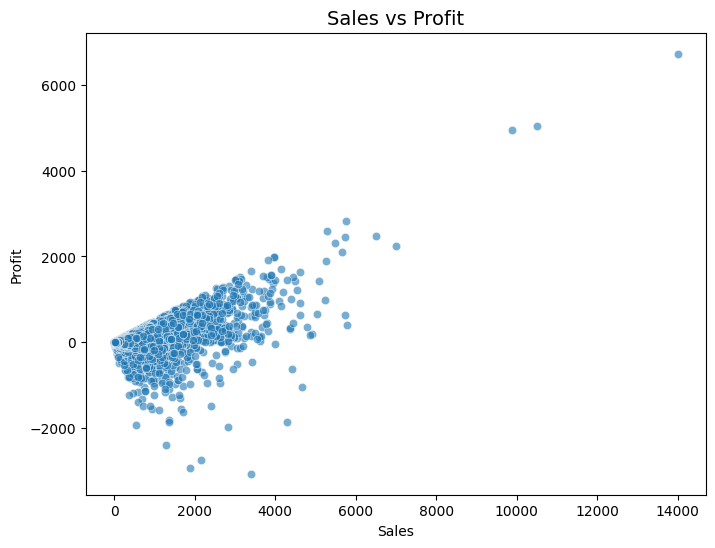

In [50]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_new, x="Sales", y="Profit", alpha=0.6)
plt.title("Sales vs Profit", fontsize=14)
plt.xlabel("Sales")
plt.ylabel("Profit")
plt.show()

Profit Distribution

d:\Anaconda\envs\quera\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


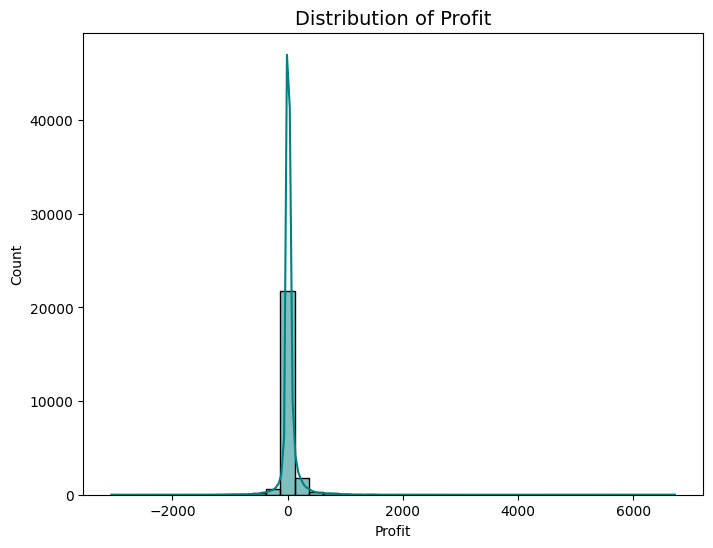

In [51]:
plt.figure(figsize=(8,6))
sns.histplot(df_new["Profit"], bins=40, kde=True, color="teal")
plt.title("Distribution of Profit", fontsize=14)
plt.xlabel("Profit")
plt.ylabel("Count")
plt.show()

Monthly Sales Trend

d:\Anaconda\envs\quera\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\quera\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


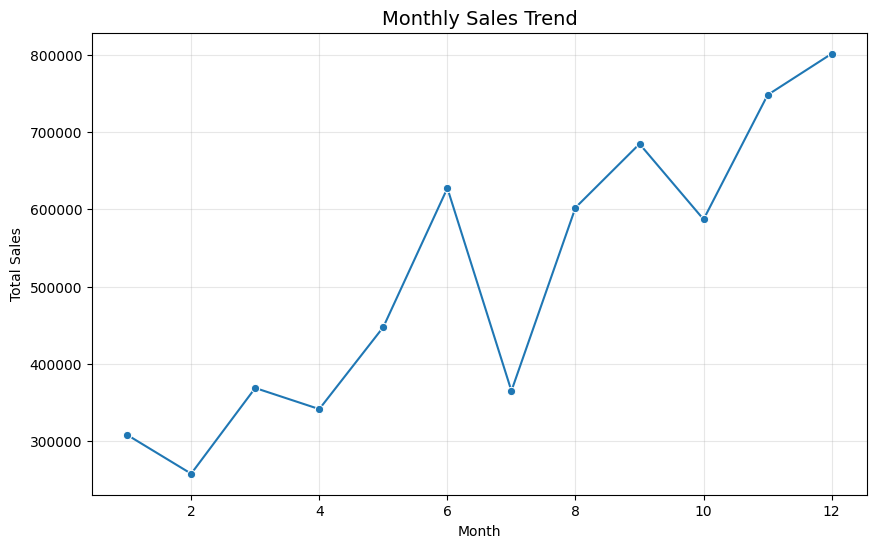

In [52]:
plt.figure(figsize=(10,6))
monthly_sales = df_new.groupby("Month")["Sales"].sum()
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker="o")
plt.title("Monthly Sales Trend", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True, alpha=0.3)
plt.show()

Average Profit by Category

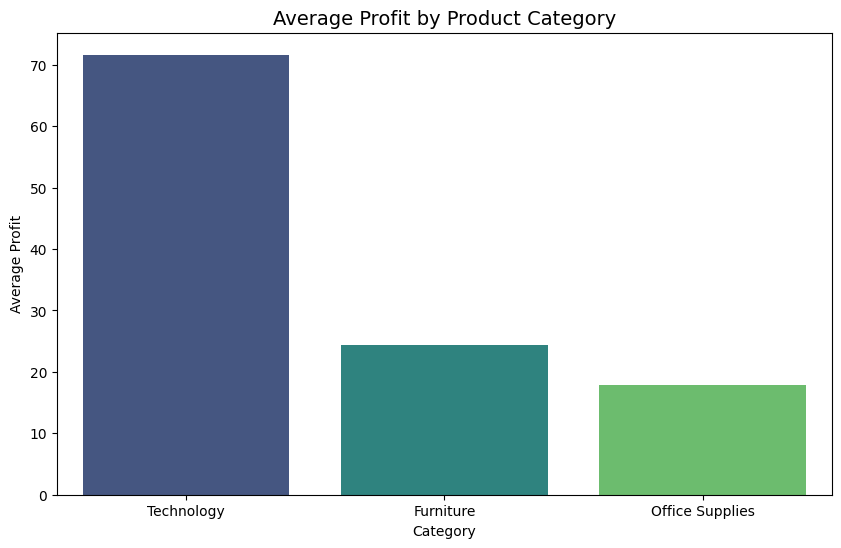

In [56]:
plt.figure(figsize=(10,6))
category_profit = df.groupby("Category")["Profit"].mean().sort_values(ascending=False)
sns.barplot(x=category_profit.index, y=category_profit.values, palette="viridis")
plt.title("Average Profit by Product Category", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Average Profit")
plt.show()